# Defi EGC 2024 - Julian Gil / Antoine Feret

## Table of contents

    1. Introduction
    2. Load data
    3. Data preprocessing
    4. Analysis
    5. Conclusion

## 1. Introduction

Miners select transactions to include in a block based on a combination of factors, including the transaction fees offered by the sender, the size of the transaction in bytes, and the available space in the block.

When a user sends a Bitcoin transaction, they have the option to include a transaction fee. This fee is paid to the miner who includes the transaction in a block and adds it to the blockchain. Transactions with higher fees are prioritized by miners because they can earn more money by including them in a block.

In addition to the transaction fee, miners also consider the size of the transaction in bytes. Larger transactions take up more space in a block, so miners may prioritize smaller transactions to maximize the number of transactions they can include in a block.

In this notebook, we will try to answer to the following question: ***how a miner should select which transactions to include in a block ?***

### 1.1 Imports

import libraries and write settings here

In [136]:
# Import of necessary libraries
%matplotlib inline

import numpy as np
from dateutil.parser import ParserError

import pandas as pd
from datetime import datetime

import json

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

pd.options.plotting.backend = "plotly"

## 2. Load Data

Load and show the data

In [137]:
# Load the data
actors_data = pd.read_csv('data/blockchain_by_actor.csv', index_col=0)
global_data = pd.read_csv('data/global.csv', index_col=0)
external_data = pd.read_csv('data/external.csv')

In [138]:
# Take a look to the data
actors_data.head()

,year,month,day,identity,received,nb_received,date,sum_fee,mean_fee_for100,nb_transactions,sent,self_spent,self_spent_estimated,nb_spent,spent
0,2015.0,1.0,1.0,HappyCoins.com,1.377590e+09,4.0,2015-01-01,49596.0,0.004957,4.0,1.277500e+09,0.0,0.0,8.0,1.277500e+09
1,2015.0,1.0,1.0,821,2.476057e+09,5.0,2015-01-01,10000.0,0.000851,1.0,1.174552e+09,0.0,0.0,2.0,1.174552e+09
2,2015.0,1.0,1.0,FortuneJack.com,1.201470e+08,29.0,2015-01-01,83000.0,0.194670,11.0,1.541127e+08,14158970.0,14158970.0,22.0,1.399538e+08
3,2015.0,1.0,1.0,396,1.906135e+10,70.0,2015-01-01,540000.0,0.023738,54.0,1.842989e+10,0.0,0.0,108.0,1.842989e+10
4,2015.0,1.0,1.0,SatoshiMines.com,7.401319e+08,193.0,2015-01-01,740000.0,0.447934,45.0,1.813624e+09,35044568.0,35044568.0,84.0,1.778579e+09


In [139]:
global_data.head()

,year,month,day,total_fee,total_received_satoshi,total_sent_satoshi,mean_fee_satoshi,mean_feeUSD,mean_fee_for100,nb_transactions,nb_payments,mean_nb_inputs,mean_nb_outputs,nb_mining,total_mining_satoshi,newly_created_coins,self_spent_satoshi,total_received,volume_without_self
2015-01-01,2015,1,1,801373971,45473028339385,45058028339385,13609.829337,4.284054e+06,0.799999,58882,161194,2.595241,2.737577,166,415801373971,415000000000,2757774885900,45473028339385,42715253453485
2015-01-02,2015,1,2,1159934218,73370568521080,72955568521080,14978.682808,4.732406e+06,0.778933,77439,257633,2.715557,3.326915,166,416159934218,415000000000,4316724676318,73370568521080,69053843844762
2015-01-03,2015,1,3,1196476043,82635189454578,82220189454578,14304.385766,4.086009e+06,0.797419,83644,295618,2.781885,3.534240,166,416196476043,415000000000,5584584356557,82635189454578,77050605098021
2015-01-04,2015,1,4,2159195328,115159442449532,114726942449532,25138.199015,6.619757e+06,0.899054,85893,280288,2.770133,3.263223,173,434659195328,432500000000,6554587956125,115159442449532,108604854493407
2015-01-05,2015,1,5,1608443040,112439228285641,112051728285641,16955.609622,4.662858e+06,0.898594,94862,286552,2.954471,3.020725,155,389108443040,387500000000,5063695492444,112439228285641,107375532793197


In [140]:
external_data.head()

,Unnamed: 0,date,PriceUSD,HashRate
0,2190,2015-01-02,315.942732,333345.017260
1,2191,2015-01-03,285.647310,327284.198765
2,2192,2015-01-04,263.334575,347486.927083
3,2193,2015-01-05,275.003852,315162.561773
4,2194,2015-01-06,287.549521,319203.107437


Also, we are going to import 3 datasets from 'Blockchain.com' chart section:
    - The average block size over the time
    - The average confirmation time of the transactions over the time
    - The *mempool* size over the time

The data for some of these graphs has only been recorded since June 2016. Therefore we will be working on data from 06/15/2016 until 06/30/2017

Definition mempool: The mempool is where all the valid transactions wait to be confirmed by the Bitcoin network. 

In [141]:
# Return the data from 2016-06-15 to 2017-6-30 of a Dataframe
def from2016_to2017(df):
    date_begin = datetime(2016, 6, 15)
    date_end = datetime(2017, 6, 30)
    #df['date'] = df['date'].apply(lambda p: datetime.strptime(p, '%Y-%m-%d'))
    df = df.loc[(df.date >= date_begin) & (df.date <= date_end)]
    return df

# Method to load a file in json format and convert it into DataFrame
def load_json_data(path): 
    # Convert json to DataFrame
    with open(path) as json_data:
        data = json.load(json_data)
        col_name = path[5:-5]
        df = pd.DataFrame(data[col_name])
    
    # Rename columns
    df.rename(columns={'x':'date', 'y':col_name}, inplace=True)

    # Change the timestamp date to the right format.
    df['date'] = df['date'].astype(str)
    df['date'] = df['date'].apply(lambda p: p[:-3])
    df['date'] = df['date'].astype(int)
    
    # Convert timestamp to DateTime
    df['date'] = df['date'].apply(lambda p: datetime.fromtimestamp(p))
    
    # Get the data from June 2016 to June 2017
    df = from2016_to2017(df)

    # Take only the date from the DateTime
    df['date'] = df['date'].apply(lambda p: p.date())
    
    # Convert Date to DateTime
    df['date'] = df['date'].apply(lambda p: datetime.combine(p, datetime.min.time()))

    return df

# Load the mempool size dataset
mempool_size_data = load_json_data('data/mempool-size.json')

# Load the average block size dataset
avg_block_size_data = load_json_data('data/avg-block-size.json')

# Load the average confirmation time dataset
avg_confirmation_time = load_json_data('data/avg-confirmation-time.json')

# Load the average confirmation time dataset
n_transactions_per_block = load_json_data('data/n-transactions-per-block.json')


## 3. Data preprocessing

In [142]:
# Put the date index as a column
global_data.reset_index(names='date', inplace=True)

# Convert str to datetime
global_data['date'] = global_data['date'].apply(lambda p: datetime.strptime(p, '%Y-%m-%d'))

# Take only the data from 2016 to 2017 June.
global_data = from2016_to2017(global_data)

In [143]:
# Concatenate the datasets from blockchain.com and the EGC dataset
blockchain_data = global_data.merge(mempool_size_data, how='inner'
                                    , on=['date']).merge(avg_block_size_data, how='inner',
                                                         on=['date']).merge(avg_confirmation_time, how='inner', on=['date']).merge(n_transactions_per_block, how='inner', on=['date'])
# Check the types
blockchain_data.dtypes

date                        datetime64[ns]
year                                 int64
month                                int64
day                                  int64
total_fee                            int64
total_received_satoshi               int64
total_sent_satoshi                   int64
mean_fee_satoshi                   float64
mean_feeUSD                        float64
mean_fee_for100                    float64
nb_transactions                      int64
nb_payments                          int64
mean_nb_inputs                     float64
mean_nb_outputs                    float64
nb_mining                            int64
total_mining_satoshi                 int64
newly_created_coins                  int64
self_spent_satoshi                   int64
total_received                       int64
volume_without_self                  int64
mempool-size                       float64
avg-block-size                     float64
avg-confirmation-time              float64
n-transacti

In [144]:
# Take a look at the newly created dataset
blockchain_data

,date,year,month,day,total_fee,total_received_satoshi,total_sent_satoshi,mean_fee_satoshi,mean_feeUSD,mean_fee_for100,...,nb_mining,total_mining_satoshi,newly_created_coins,self_spent_satoshi,total_received,volume_without_self,mempool-size,avg-block-size,avg-confirmation-time,n-transactions-per-block
0,2016-06-15,2016,6,15,8046459191,226623268595599,226273268595599,32496.765819,2.258530e+07,1.085912,...,140,358046459191,350000000000,8195742382265,226623268595599,218427526213334,2.346226e+07,0.917150,67.982068,1705.276316
1,2016-06-18,2016,6,18,6973505804,228474542475358,228094542475358,30015.649377,2.276053e+07,1.243319,...,152,386973505804,380000000000,4629590873986,228474542475358,223844951601372,2.075233e+07,0.867728,42.948742,1489.348101
2,2016-06-27,2016,6,27,5954426908,213403256973000,213048256973000,28257.396785,1.843074e+07,1.370733,...,142,360954426908,355000000000,6238204241455,213403256973000,207165052731545,1.521212e+06,0.777207,15.269865,1476.387755
3,2016-06-30,2016,6,30,6139497628,203913567412716,203541067412716,26703.104285,1.800550e+07,1.164666,...,149,378639497628,372500000000,7228636670000,203913567412716,196684930742716,3.164595e+06,0.797510,21.966970,1546.400000
4,2016-07-03,2016,7,3,4555170477,176004303209408,175629303209408,25675.082726,1.701103e+07,1.494692,...,150,379555170477,375000000000,22314806477579,176004303209408,153689496731829,2.648298e+06,0.614649,15.719164,1150.175325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2017-06-07,2017,6,7,65906347674,253466681030666,253265431030666,197255.886201,5.339243e+08,3.515740,...,161,267156347674,201250000000,8921088394377,253466681030666,244545592636289,7.179373e+07,0.992123,98.002750,2058.909091
71,2017-06-16,2017,6,16,37911415737,352326930464184,352136930464184,137127.681095,3.395774e+08,3.175732,...,152,227911415737,190000000000,11335802516740,352326930464184,340991127947444,5.712907e+07,0.983088,396.995360,1823.898649
72,2017-06-19,2017,6,19,36996704803,297827133419312,297634633419312,142186.737804,3.682128e+08,3.137884,...,154,229496704803,192500000000,11651822312460,297827133419312,286175311106852,2.358836e+07,0.986316,973.237521,1786.582781
73,2017-06-22,2017,6,22,46416640342,347747446654960,347569946654960,168306.731821,4.521809e+08,3.426576,...,142,223916640342,177500000000,19360856199415,347747446654960,328386590455545,2.879930e+07,0.992578,74.979024,1940.179856


## 4. Analysis

### 4.1. More low or higher fees ?

We can start by loading the Blockchain dataset and plotting the distribution of transaction fees:

<Axes: xlabel='mean_fee_satoshi', ylabel='Count'>

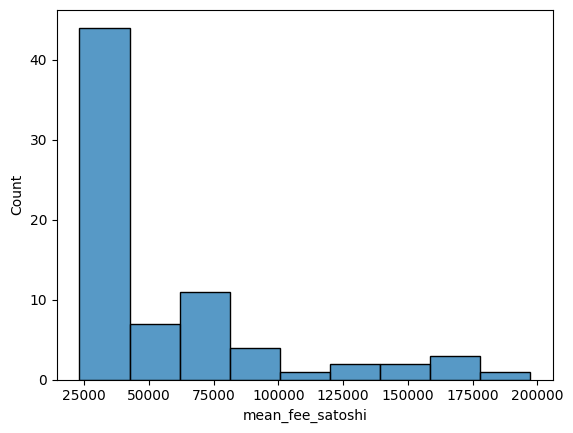

In [145]:
sns.histplot(data=blockchain_data, x='mean_fee_satoshi')

From the chart, we can see that the majority of transactions have low fees, with a few transactions offering significantly higher fees. This suggests that miners have a choice between including more low-fee transactions or fewer high-fee transactions in a block.

### 4.2. Fees and congestion?

Next, we can explore the relationship between the transaction fees and the likelihood of a transaction being included in a block. Miners prioritize transactions with higher fees, so we can expect to see a correlation between the transaction fee and the time it takes for a transaction to be confirmed.

<Axes: xlabel='avg-block-size', ylabel='avg-confirmation-time'>

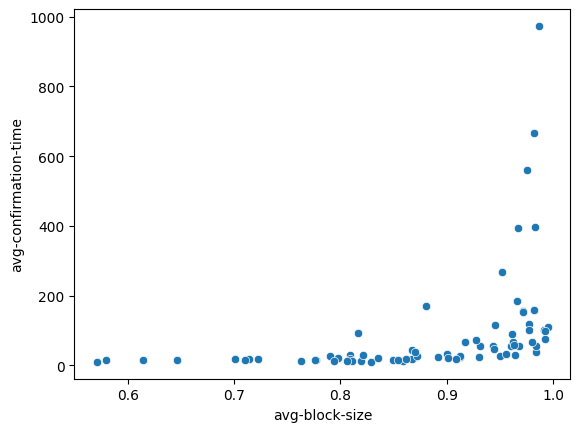

In [146]:
sns.scatterplot(data=blockchain_data, x='avg-block-size', y='avg-confirmation-time')

we see that when the block is overloaded the confirmation time fees explode

<Axes: xlabel='avg-block-size', ylabel='mean_fee_satoshi'>

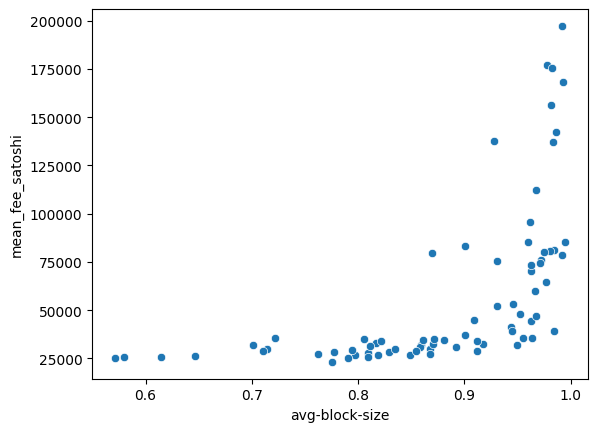

In [147]:
sns.scatterplot(data=blockchain_data, x='avg-block-size', y='mean_fee_satoshi')


we see that when the block is overloaded the price of transaction fees explode

### 4.3. Size of transactions over the time

Something really important to understand is that miners are paid by the transactions fees for each transaction included in a block and also the reward for adding a new block in the blockchain.

The reward for adding a new block is a fixed value of BTC. In the future, it will become 0, fees will be the main mining incentive Therefore the fees size can be roughly estimated with the number of inputs and the number of outputs.

We chan check how the size of the transaction changes over time.

<Axes: xlabel='date', ylabel='mean_estimation_size_transaction'>

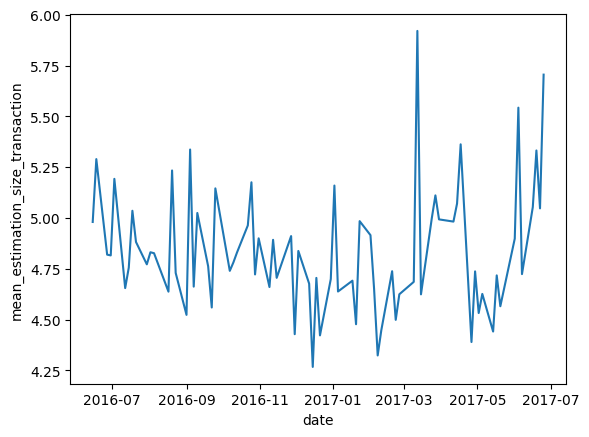

In [148]:
# Create a new column to estimatate mean transaction size
blockchain_data['mean_estimation_size_transaction'] = blockchain_data['mean_nb_outputs'] + blockchain_data['mean_nb_inputs']
sns.lineplot(data=blockchain_data, x='date', y='mean_estimation_size_transaction')

We can see that the mean of transactions size is not stable over the time, indicating that the size of the average transaction is inconsistent.
Therefore, it is not enough for miners to simply choose a transaction based on its fees.

Miners also need to consider transaction size. Indeed, it is more interesting to include 2 transactions at 25 dollars rather than one at 35 dollars. We can verify that affirmation by plotting the correlation between mean size of transactions and the number of transactions of a block

<Axes: xlabel='n-transactions-per-block', ylabel='mean_estimation_size_transaction'>

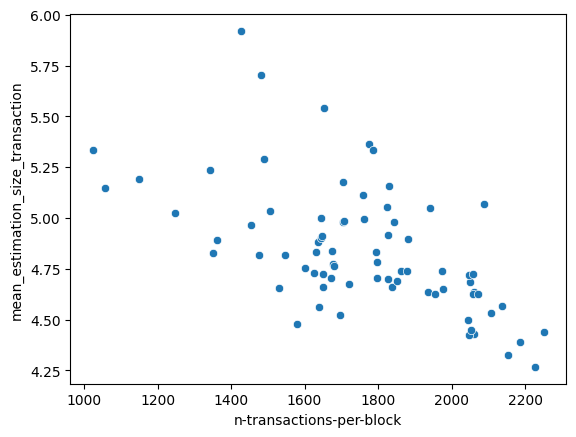

In [149]:
sns.scatterplot(data=blockchain_data, x='n-transactions-per-block', y='mean_estimation_size_transaction')

We can see a negative correlation between the avegare size of a transaction and the average number of transaction inside a block. It means well that miners have to choose carefully the transactions to include in the a block.

### 4.4. Combines all the factors

In [150]:
# add a column is_big_transaction, True if the mean size transaction is higher that the total mean
blockchain_data['is_big_transaction'] = blockchain_data['mean_estimation_size_transaction'] > blockchain_data['mean_estimation_size_transaction'].mean()

fig = px.scatter(blockchain_data, x='mean_fee_for100', y='avg-block-size', log_x=True, color='is_big_transaction',
                 title="Transactions characteristics",
                 size='mempool-size', size_max=15)

fig

The graph above allows us to see that the transactions with the highest fees are also the transactions with the highest sizes. We see that this phenomenon intensifies when the size of the blocks and the size of the mempool increase.

## 5. Conclusion

Based on the exploratory analysis of the three datasets, we can draw some insights into how a miner might select which transactions to include in a block:

Miners should prioritize transactions with the highest fee/size of the transaction. These rates are highest when the memory pool is overloaded. Minors must therefore be very attentive at these times.
The rest of the time the value of transaction fees is relatively stable, so miners can choose transactions in the order they come.